In [4]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import json
import talib
import mplfinance as mpf
import numpy as np
from datetime import datetime, timezone
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [5]:
stock_num = "2330"

In [7]:
df = yf.download(stock_num + ".TWO", start = "2017-01-01")

if df.empty:
    df = yf.download(stock_num + ".TW", start = "2017-01-01")
    

df = df.round(2)
df.iloc[-1]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 2330.TWO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


Open              400.5
High              403.0
Low               398.0
Close             400.0
Adj Close         400.0
Volume       24757091.0
Name: 2022-10-13 00:00:00, dtype: float64

我的算法  
  
計算起始日至今天的20WMA及正負乖離率  
天花板線 => 正乖離率小到大排序後的第95%筆當作門檻值 每天的天花板值 = (1 + 門檻值) * 20WMA  
地板線 => 負乖離率小到大排序後的第5%筆當作門檻值 每天的地板值 = (1 + 門檻值) * 20WMA  

In [5]:
pos_BIAS = []
neg_BIAS = []
support = [np.nan for i in range(20)]
resistance = [np.nan for i in range(20)]
wma_20 = talib.WMA(df["Close"], timeperiod = 20)

for i in range(20, len(wma_20), 1):
    temp = (float(df["Close"][i]) - wma_20[i]) / wma_20[i]
    
    if temp >= 0:
        pos_BIAS.append(round(float(temp), 4))
    else:
        neg_BIAS.append(round(float(temp), 4))

pos_BIAS.sort()
neg_BIAS.sort()

pos_BIAS_val = float(pos_BIAS[int(len(pos_BIAS) * 0.95) - 1])
neg_BIAS_val = float(neg_BIAS[int(len(neg_BIAS) * 0.05) - 1])

for i in range(20, len(wma_20), 1):
    support.append(round((1 + neg_BIAS_val) * wma_20[i], 2))
    resistance.append(round((1 + pos_BIAS_val) * wma_20[i], 2))

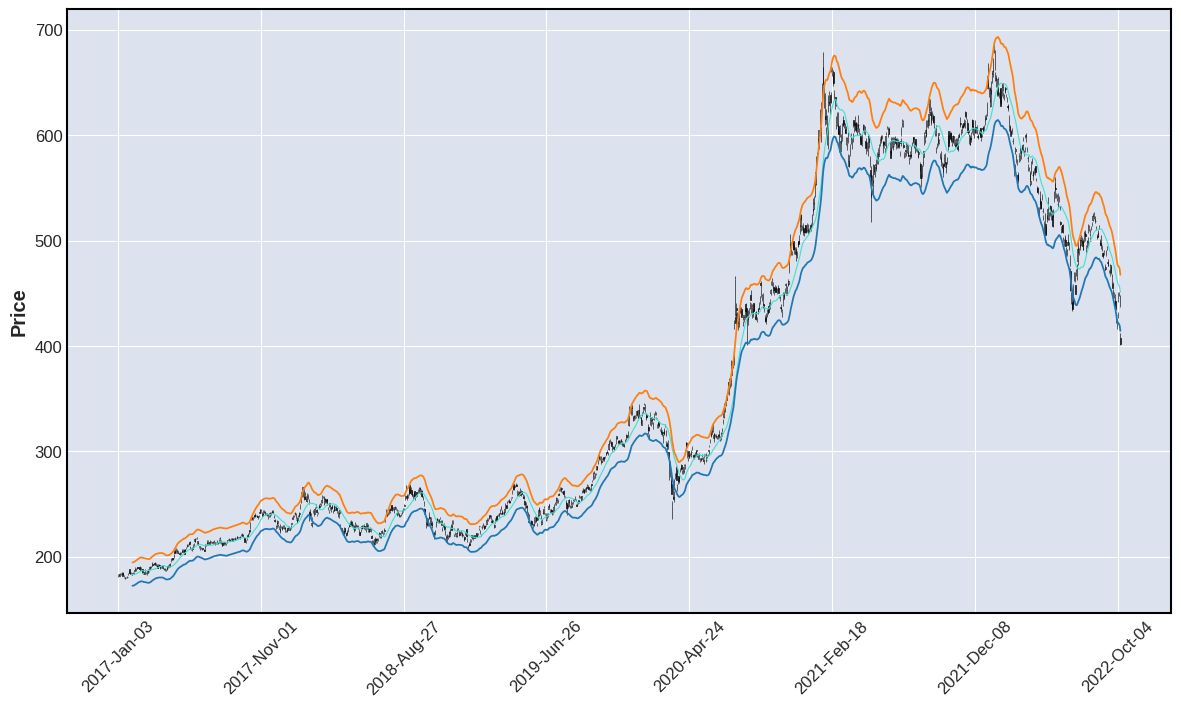

In [6]:
apds = [mpf.make_addplot(support, secondary_y = False), mpf.make_addplot(resistance, secondary_y = False)]

mpf.plot(df, type = 'candle', addplot = apds, mav = 20, figscale = 1.5, figratio = (16,9))

建錡的算法  
  
計算MA及乖離率
地板線 => 月均線 - 月均線 * (乖離率 - 2倍標準差)

In [7]:
ma_20 = talib.MA(df["Close"], timeperiod = 20)

In [8]:
BIAS = []

for i in range(20, len(ma_20), 1):
    if df["Close"][i] < ma_20[i]:
        temp = (float(df["Close"][i]) - ma_20[i]) / ma_20[i]
        BIAS.append(temp)

BIAS_std = np.std(BIAS)

In [9]:
support = [np.nan for i in range(20)]

for i in range(20, len(ma_20), 1):
    temp = ma_20[i] * (1 + (np.mean(BIAS) - 2 * BIAS_std))
    support.append(round(temp, 2))

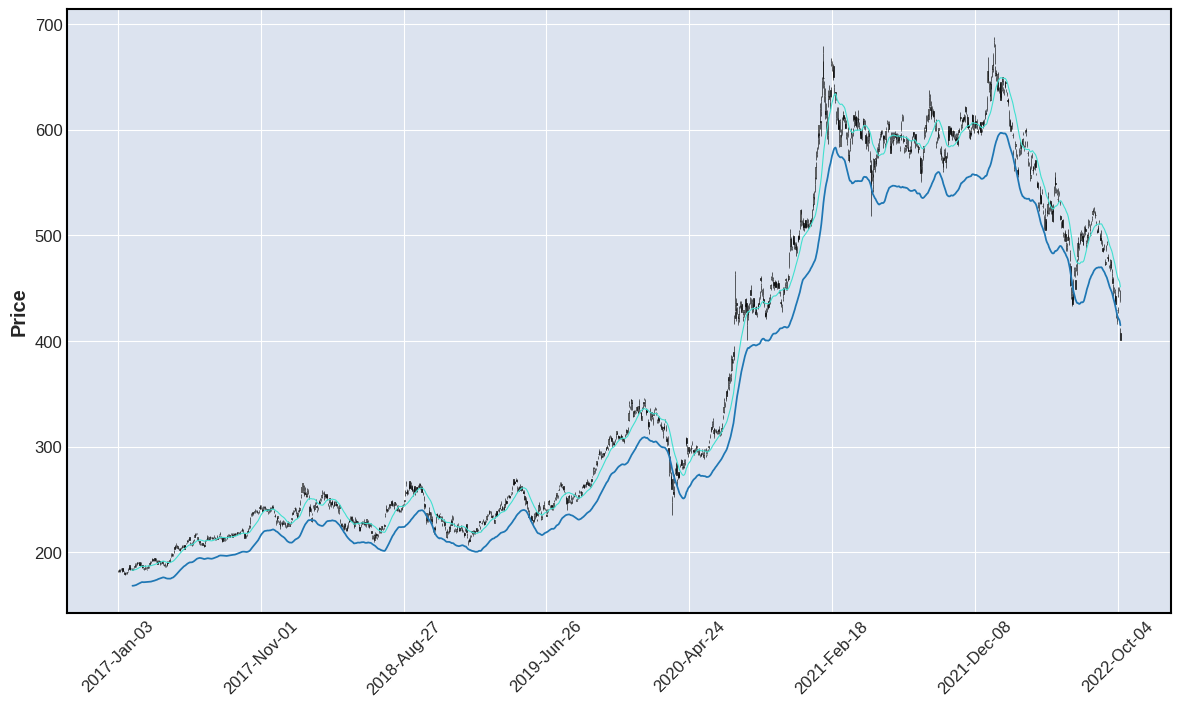

In [10]:
apds = [mpf.make_addplot(support, secondary_y = False)]

mpf.plot(df, type = 'candle', addplot = apds, mav = 20, figscale = 1.5, figratio = (16,9))

建瑆的做法  
  
計算20MA及乖離率  
乖離率由大到小排序後取得前5%與1%當作門檻值  
當天成交量必須大於2倍的20MA均量線才符合

In [15]:
ma_20 = talib.MA(df["Close"], timeperiod = 20)

In [16]:
BIAS.sort()
BIAS_1 = BIAS[int(len(BIAS) * 0.01)]
BIAS_5 = BIAS[int(len(BIAS) * 0.05)]

In [17]:
vol_avg_20 = df["Volume"][len(df) - 2 - 19: len(df) - 2].sum() / 20

if df["Volume"][-1] > 2 * vol_avg_20:
    print(1)
else:
    print(0)

1


In [20]:
support1 = [np.nan for i in range(20)]
support2 = [np.nan for i in range(20)]

for i in range(20, len(ma_20), 1):
    support1.append(round(ma_20[i] + ma_20[i] * BIAS_1, 2))
    support2.append(round(ma_20[i] + ma_20[i] * BIAS_5, 2))

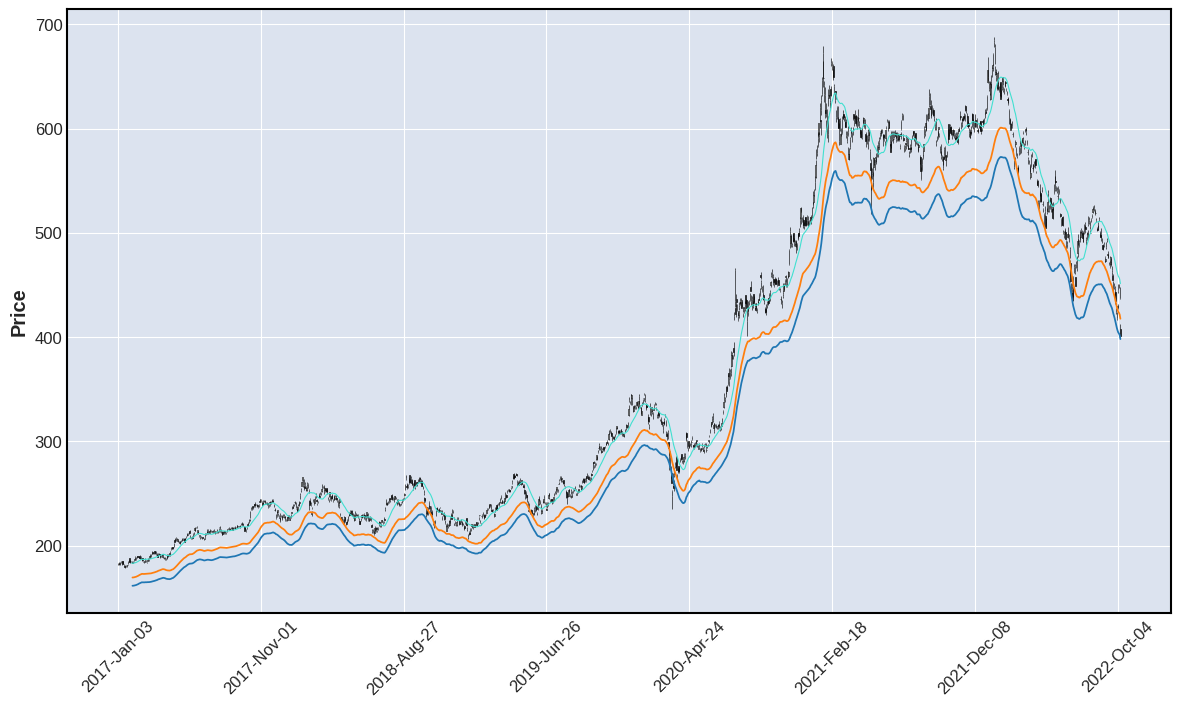

In [21]:
apds = [mpf.make_addplot(support1, secondary_y = False), mpf.make_addplot(support2, secondary_y = False)]

mpf.plot(df, type = 'candle', addplot = apds, mav = 20, figscale = 1.5, figratio = (16,9))